In [ ]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def get_rays(height, width, focal_length, c2w):
    # Create meshgrid for pixel coordinates in the image plane
    i, j = torch.meshgrid(
        torch.arange(width, dtype=torch.float32).to(c2w.device),
        torch.arange(height, dtype=torch.float32).to(c2w.device),
        indexing='xy'  # Computer Graphics convention
    )

    # Compute directions in camera coordinates
    directions = torch.stack([
         (i - width * 0.5) / focal_length,
        -(j - height * 0.5) / focal_length,
        -torch.ones_like(i)
    ], dim=-1)  # (height, width, 3)

    # Convert directions to world coordinates
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

    # Camera origin in world coordinates
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d


def sampling(ray_origins, tn, tf, n_bins, perturb=True):
    # number_of_rays = batch_size
    # ray_origins: (number_of_rays, 3)
    device = ray_origins.device

    # Get t values for sampling along each ray
    t = torch.linspace(tn, tf, n_bins, device=device)  # (n_bins)
    t = t.expand(ray_origins.shape[0], n_bins)         # (number_of_rays, n_bins): Repeat for all rays

    # Draw uniform samples from bins along ray (Stratified Sampling)
    if perturb:
        mid = (t[:, :-1] + t[:, 1:]) / 2.
        lower = torch.cat((t[:, :1], mid), -1)
        upper = torch.cat((mid, t[:, -1:]), -1)
        u = torch.rand(t.shape, device=device)
        t = lower + (upper - lower) * u  # (number_of_rays, n_bins)

    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)
    # (number_of_rays, n_bins): Distance between each bin along the ray

    return t, delta


def compute_accumulated_transmittance(alphas):
    # alphas: (number_of_rays, n_bins)

    accumulated_transmittance = torch.cumprod(alphas, dim=1)
    # (number_of_rays, n_bins): Accumulated transmittance at each bin

    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device)
    # (number_of_rays, 1): Transmittance at the first bin is 1

    transmittance = torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1)
    return transmittance  # (number_of_rays, n_bins): Transmittance at each bin


def render_rays(nerf_model, ray_origins, ray_directions, tn=0, tf=0.5, n_bins=192, perturb=True):
    # number_of_rays = batch_size
    # ray_origins: (number_of_rays, 3)
    # ray_directions: (number_of_rays, 3)

    t, delta = sampling(ray_origins, tn, tf, n_bins, perturb)
    
    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)   # (number_of_rays, n_bins, 3)

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(n_bins, ray_directions.shape[0], 3).transpose(0, 1)  
    # (number_of_rays, n_bins, 3); Repeat the same direction for all bins

    # (number_of_rays*n_bins, 3), (number_of_rays*n_bins, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)     # (number_of_rays, n_bins, 3)
    sigma = sigma.reshape(x.shape[:-1])  # (number_of_rays, n_bins)

    # Compute weights
    alpha = 1 - torch.exp(-sigma * delta)  # (number_of_rays, n_bins)
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    # (number_of_rays, n_bins, 1)

    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    # (number_of_rays, n_bins, 1) * (number_of_rays, n_bins, 3) -> (number_of_rays, 3)
    return c  # (number_of_rays, 3)

In [ ]:
class NeRF(nn.Module):
    def __init__(self, emb_dim_pos=10, emb_dim_dir=4, hidden_dim=128):
        super().__init__()
        self.emb_dim_pos = emb_dim_pos
        self.emb_dim_dir = emb_dim_dir

        self.block1 = nn.Sequential(
            nn.Linear(6*emb_dim_pos+3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_pos+3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, 1), nn.ReLU()        # non-negative
        )
        self.color = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_dir+3, hidden_dim//2), nn.ReLU(),
            nn.Linear(hidden_dim//2, 3), nn.Sigmoid()  # RGB color
        )

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)
    
    def forward(self, x, d):
        emb_x = self.positional_encoding(x, self.emb_dim_pos)  # (batch_size, 6*emb_dim_pos+3)
        emb_d = self.positional_encoding(d, self.emb_dim_dir)  # (batch_size, 6*emb_dim_dir+3)
        h = self.block1(emb_x)           # (batch_size, hidden_dim)
        h = torch.cat((h, emb_x), dim=1) # skip connection: (batch_size, hidden_dim + 6*emb_dim_pos+3)
        h = self.block2(h)               # (batch_size, hidden_dim)
        sig = self.sigma(h)              # (batch_size, 1)
        h = torch.cat((h, emb_d), dim=1) # viewing direction condition: (batch_size, hidden_dim + 6*emb_dim_dir+3)
        c = self.color(h)                # (batch_size, hidden_dim//2)
        return c, sig

In [ ]:
class NeRFDataset(Dataset):
    def __init__(self, images, ray_origins, ray_directions):
        self.images = images
        self.ray_origins = ray_origins
        self.ray_directions = ray_directions

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.ray_origins[idx], self.ray_directions[idx]

In [ ]:
@torch.inference_mode()
def test(nerf_model, tn, tf, ray_origins, ray_directions, chunk_size=10, n_bins=192, H=100, W=100, filename=None):
    """
    Args:
        nerf_model: NeRF model
        tn: near plane distance
        tf: far plane distance
        ray_origins: ray origins for each pixel of the image
        ray_directions: ray directions for each pixel of the image
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        n_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 100.
        W (int, optional): image width. Defaults to 100.
        
    Returns:
        None: None
    """

    pixels = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_o = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(ray_origins.device)
        ray_d = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(ray_origins.device)        
        regenerated_px_values = render_rays(nerf_model, ray_o, ray_d, tn=tn, tf=tf, n_bins=n_bins)
        pixels.append(regenerated_px_values)
    img = torch.cat(pixels).data.cpu().numpy().reshape(H, W, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.axis('off')
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    return img


def train(nerf_model, optimizer, scheduler, data_loader, device='cpu', n_epochs=int(1e5),
          tn=0, tf=1, n_bins=192, H=100, W=100, freq=10000,
          test_ray_o=None, test_ray_d=None, output_dir='output'):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    losses = []
    for epoch in range(n_epochs):
        train_loader = tqdm(data_loader)
        train_loader.set_description(f'Epoch {epoch}')
        for batch_idx, batch in enumerate(train_loader):
            global_step = epoch * len(data_loader) + batch_idx
            ground_truth_px_values = batch[0].to(device)
            ray_origins = batch[1].to(device)
            ray_directions = batch[2].to(device)

            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, tn=tn, tf=tf, n_bins=n_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if global_step % freq == 0:
                test(nerf_model, tn, tf, test_ray_o, test_ray_d, chunk_size=10, n_bins=n_bins, H=H, W=W,
                     filename=output_dir / f'img_{global_step}.png')
                
                torch.save(nerf_model.state_dict(), output_dir / f'model_{global_step}.pth')
        print(f'Epoch {epoch} Loss: {losses[-1]}')
        scheduler.step()

    torch.save(nerf_model.state_dict(), output_dir / 'model.pth')
    return losses

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)
ray_origin_list = []
ray_direction_list = []
for i in range(images.shape[0]):
    height, width = images[i].shape[:2]
    with torch.inference_mode():
        ray_origin, ray_direction = get_rays(height, width, focal, poses[i])
    ray_origin_list.append(ray_origin)
    ray_direction_list.append(ray_direction)
ray_origins = torch.stack(ray_origin_list, dim=0)
ray_directions = torch.stack(ray_direction_list, dim=0)

n_train = 100
train_images = images[:n_train].view(-1, 3)
train_ray_origins = ray_origins[:n_train].view(-1, 3)
train_ray_directions = ray_directions[:n_train].view(-1, 3)

dataset = NeRFDataset(train_images, train_ray_origins, train_ray_directions)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [ ]:
model = NeRF(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

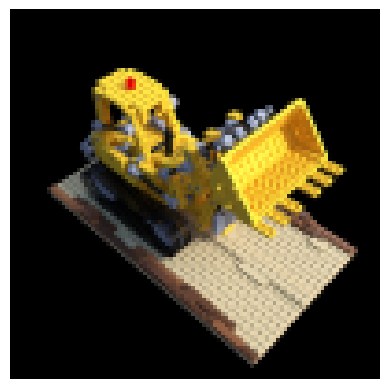

In [ ]:
idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 0 Loss: 9.962289810180664


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 1 Loss: 7.909558296203613


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 2 Loss: 6.234469413757324


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 3 Loss: 6.4733991622924805


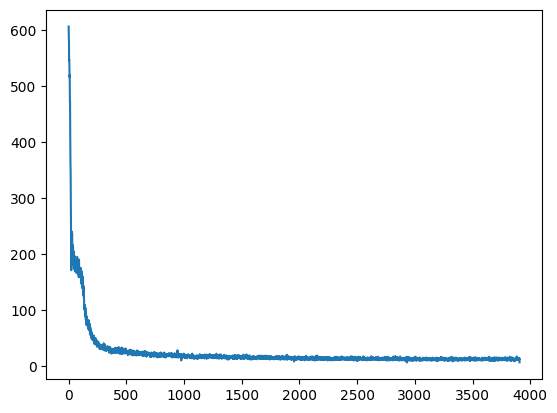

In [ ]:
losses = train(model, optimizer, scheduler, dataloader, device=device, n_epochs=4, freq=500,
               tn=2, tf=6, n_bins=192, H=100, W=100,
               test_ray_o=test_ray_o, test_ray_d=test_ray_d)

plt.plot(losses);

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

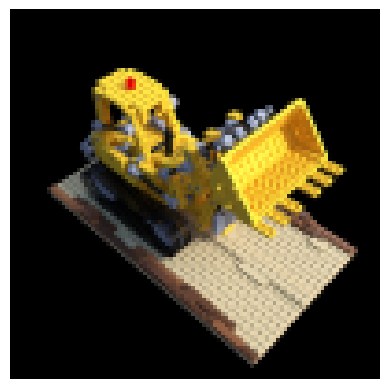

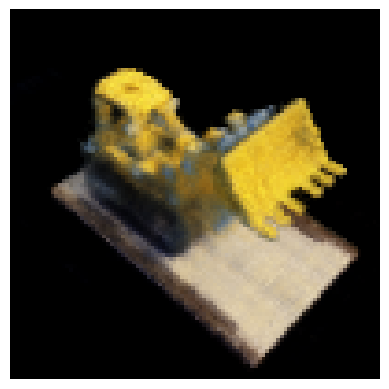

PSNR: 23.645374298095703
SSIM: 0.8356645703315735


In [ ]:
model = NeRF(hidden_dim=128).to(device)
model.load_state_dict(torch.load('output/model.pth', map_location=device, weights_only=True))

idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

pred_img = test(model, 2, 6, test_ray_o, test_ray_d)
pred_img = torch.from_numpy(pred_img)

# (H, W, 3) -> (1, 3, H, W)
pred_img = pred_img.permute(2, 0, 1).unsqueeze(0).cpu()
test_img = test_img.permute(2, 0, 1).unsqueeze(0).cpu()

psnr = PeakSignalNoiseRatio(data_range=1.0)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
psnr_val = psnr(pred_img, test_img)
ssim_val = ssim(pred_img, test_img)
print(f'PSNR: {psnr_val}')
print(f'SSIM: {ssim_val}')